## **Penjelasan Singkat tentang FaceNet - Proyek Pengenalan Wajah untuk Absensi**

Proyek ini bertujuan untuk membangun **Sistem Pengenalan Wajah** untuk pencatatan absensi dengan melakukan fine-tuning pada model dasar, yaitu **FaceNet**. Berikut adalah penjelasan detail tentang alur kerja proyek ini:

---

### **Dataset**
- Dataset yang digunakan terdiri dari:
  - **500 gambar diri sendiri** untuk keperluan training.
  - **10.000 gambar orang lain** yang diambil dari **Labeled Faces in the Wild (LFW)** dataset.
- Proses preprocessing dilakukan menggunakan skrip `collectImages_FINALFIX.ipynb`, sehingga semua gambar diformat dan diselaraskan dengan benar untuk pelatihan.

---

### **Deteksi Wajah**
- **Detektor wajah berbasis DNN (Deep Neural Network)** digunakan untuk **memotong area wajah** dalam dataset.
- Gambar wajah hasil cropping kemudian digunakan sebagai data pelatihan model FaceNet.

---

### **Pengujian dan Mekanisme Absensi**
Proyek ini menyediakan dua metode pengujian yang berbeda:
1. **Pengujian Secara Real-Time**:
   - Absensi dilakukan secara **real-time** dengan mencocokkan wajah yang terdeteksi dengan database yang telah diregistrasi.
   - Verifikasi lokasi dilakukan melalui pencocokan dengan **IP ruangan**.
2. **Pengujian Snapshot**:
   - Model diuji menggunakan gambar yang telah diambil sebelumnya (snapshot), sehingga absensi tetap dapat dilakukan tanpa koneksi real-time.

---

### **Fitur Utama**
- **Model Dasar**: Model FaceNet yang di-fine-tune untuk menghasilkan pengenalan wajah yang akurat.
- **Otomasi UjiCoba**: Proses absensi berlangsung secara otomatis dan andal berkat pencocokan wajah real-time.

## Import Libraries

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import json
import random
import socket
import psutil

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Dataset dan Preprocessing

Dataset diambil dengan menggunakan 500 gambar diri (Michael Dimas Chrispradipta) sebagai data positive dan 10000 gambar dari LFW sebagai data negative

In [2]:
# Definisi Directory untuk Crop Images

input_folders = {
    "me": "DATASET/me",
    "not_me": "DATASET/not_me"
}

output_folders = {
    "me": "DATASET_preprocessed/me",
    "not_me": "DATASET_preprocessed/not_me"
}

for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)


In [6]:
# Load the DNN model untuk Face Detector
model_path = "DNN/deploy.prototxt"  # Replace with your deploy.prototxt path
weights_path = "DNN/res10_300x300_ssd_iter_140000.caffemodel"  # Replace with your model weights path
net = cv2.dnn.readNetFromCaffe(model_path, weights_path)

# Function untuk crop faces dari images
def get_faceCropped():
    me_counter = 0
    no_counter = 0
    failed_counter = 0

    for label, input_folder in input_folders.items():
        output_folder = output_folders[label]
        for img_name in os.listdir(input_folder):
            img_path = os.path.join(input_folder, img_name)

            # Read the image
            image = cv2.imread(img_path)
            if image is None:
                print(f"Skipped {img_path}, not a valid image.")
                continue

            # Extract image dimensions
            (h, w) = image.shape[:2]

            # Prepare the image based on DNN model Requirement
            blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                         mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
            net.setInput(blob)
            detections = net.forward()

            face_detected = False
            for i in range(0, detections.shape[2]):
                confidence = detections[0, 0, i, 2]
                if confidence > 0.5:  # Confidence threshold
                    box = detections[0, 0, i, 3:7] * [w, h, w, h]
                    (x1, y1, x2, y2) = box.astype("int")

                    # Ensure bounding box stays within image dimensions
                    x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

                    # Proses Crop and save the face
                    face = image[y1:y2, x1:x2]
                    output_path = os.path.join(output_folder, img_name)
                    cv2.imwrite(output_path, face)
                    print(f"Cropped face saved to {output_path}")
                    face_detected = True
                    
                    # Process tracking jumlah data cropped
                    if input_folder == "DATASET/me":
                        print("In me")    
                        me_counter += 1
                    
                    else:
                        print("In not me")    
                        no_counter += 1

            if not face_detected:
                # Menghitung gambar gagal
                print(f"No face detected in {img_path}.")
                failed_counter += 1

    print(f"Total me faces cropped: {me_counter}")
    print(f"Total not me faces cropped: {no_counter}")
    print(f"Total failed to detect faces: {failed_counter}")

# Call the function
get_faceCropped()


Cropped face saved to DATASET_preprocessed/me\me_0.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_1.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_10.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_100.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_101.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_102.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_103.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_104.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_105.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_106.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_107.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_108.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_109.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_11.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_110.jpg
In me
Cropped face saved to DATASET_preprocessed/me\me_111.jpg
In m

In [3]:
# Dataset path untuk gambar yang telah cropped
ME_PATH = "DATASET_preprocessed/me/"
NOT_ME_PATH = "DATASET_preprocessed/not_me/"

# Path dataset dan set up classes index
dataset_path = "./DATASET_preprocessed"
output_path = "./DATASET_SPLIT"
classes = ["not_me", "me"]  # Class names

# Ratio
train_ratio = 0.7  # 70% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.1   # 10% for testing

# Hyperparameters yang digunakan
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.001
IMG_SIZE = (224, 224)

In [8]:
# Create output directories untuk Splitting dataset

for split in ['train', 'validation', 'test']:
    for class_name in classes:
        os.makedirs(os.path.join(output_path, split, class_name), exist_ok=True)

# Split data
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Split into train, validation, and test sets
    train_val_imgs, test_imgs = train_test_split(images, test_size=test_ratio, random_state=42)
    train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

    # Move files to respective directories
    for img in train_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_path, 'train', class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_path, 'validation', class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_path, 'test', class_name, img))

print("Dataset successfully split into train, validation, and test sets!")

Dataset successfully split into train, validation, and test sets!


In [9]:
# Load data dalam datagen 3 splitting dan apply augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

val_test_datagen = ImageDataGenerator(
    rescale=1.0 / 255  # Hanya rescale for validation and test sets
)

# Paths to the split dataset
train_dir = "./DATASET_SPLIT/train"
val_dir = "./DATASET_SPLIT/validation"
test_dir = "./DATASET_SPLIT/test"

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    classes=['not_me', 'me'],
    subset="training",
)

validation_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    classes=['not_me', 'me'],
)

test_generator = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    classes=['not_me', 'me'],
    shuffle=False
)

Found 5817 images belonging to 2 classes.
Found 2079 images belonging to 2 classes.
Found 1039 images belonging to 2 classes.


## Prepare Model Deep Learning & Training

In [4]:
# Pre-trained face recognition models (to add other frameworks, you'll need wrappers for TensorFlow or PyTorch models)
def get_facenet(input_shape):
    from keras_facenet import FaceNet
    return FaceNet().model

# Get base model
def get_base_model(model_name, input_shape=(224, 224, 3)):
    if model_name not in pretrained_models:
        raise ValueError(f"Model '{model_name}' not in the supported models: {list(pretrained_models.keys())}")
    return pretrained_models[model_name](input_shape)

In [13]:
# Select model Face Recognizer
model_name = "FaceNet"
base_model = get_base_model(model_name, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False
    
# Tambahan custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification (me vs. not me)

model = Model(inputs=base_model.input, outputs=predictions)


# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="binary_crossentropy", metrics=["accuracy"])

In [74]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_1a_3x3       │ (None, None,      │        864 │ input_layer_4[0]… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_1a_3x3_Batc… │ (None, None,      │         96 │ Conv2d_1a_3x3[0]… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_1a_3x3_Acti… │ (None, None,      │          0 │ Conv2d_1a_3x3_Ba… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_2a_3x3       │ (None, None,      │      9,216 │ Conv2d_1a_3x3_Ac… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_2a_3x3_Batc… │ (None, None,      │         96 │ Conv2d_2a_3x3[0]… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_2a_3x3_Acti… │ (None, None,      │          0 │ Conv2d_2a_3x3_Ba… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_2b_3x3       │ (None, None,      │     18,432 │ Conv2d_2a_3x3_Ac… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_2b_3x3_Batc… │ (None, None,      │        192 │ Conv2d_2b_3x3[0]… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_2b_3x3_Acti… │ (None, None,      │          0 │ Conv2d_2b_3x3_Ba… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MaxPool_3a_3x3      │ (None, None,      │          0 │ Conv2d_2b_3x3_Ac… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_3b_1x1       │ (None, None,      │      5,120 │ MaxPool_3a_3x3[0… │
│ (Conv2D)            │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_3b_1x1_Batc… │ (None, None,      │        240 │ Conv2d_3b_1x1[0]… │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_3b_1x1_Acti… │ (None, None,      │          0 │ Conv2d_3b_1x1_Ba… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_4a_3x3       │ (None, None,      │    138,240 │ Conv2d_3b_1x1_Ac… │
│ (Conv2D)            │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_4a_3x3_Batc… │ (None, None,      │        576 │ Conv2d_4a_3x3[0]… │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv2d_4a_3x3_Acti… │ (None, None,      │          0 │ Conv2d_4a_3x3_Ba

 Total params: 23,694,805 (90.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,563,217 (89.89 MB)

 Optimizer params: 131,588 (514.02 KB)

In [14]:
# Proses training

# Early stopping saat model kurang efektif belajar
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9440 - loss: 0.2951

c:\Users\Michael Dimas\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.9441 - loss: 0.2944 - val_accuracy: 0.9902 - val_loss: 0.0458
Epoch 2/15
  1/181 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - accuracy: 1.0000 - loss: 0.0159

c:\Users\Michael Dimas\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


181/181 ━━━━━━━━━━━━━━━━━━━━ 61s 334ms/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 0.9902 - val_loss: 0.0465
Epoch 3/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.9832 - loss: 0.0584 - val_accuracy: 0.9932 - val_loss: 0.0269
Epoch 4/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 65s 352ms/step - accuracy: 1.0000 - loss: 0.0167 - val_accuracy: 0.9937 - val_loss: 0.0267
Epoch 5/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.9875 - loss: 0.0440 - val_accuracy: 0.9961 - val_loss: 0.0188
Epoch 6/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 63s 348ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9956 - val_loss: 0.0184
Epoch 7/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.9899 - loss: 0.0302 - val_accuracy: 0.9971 - val_loss: 0.0149
Epoch 8/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 58s 317ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.9971 - val_loss: 0.0149
Epoch 9/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9880 - loss: 0.0361 - val_accurac

## Evaluation Result

33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 897ms/step


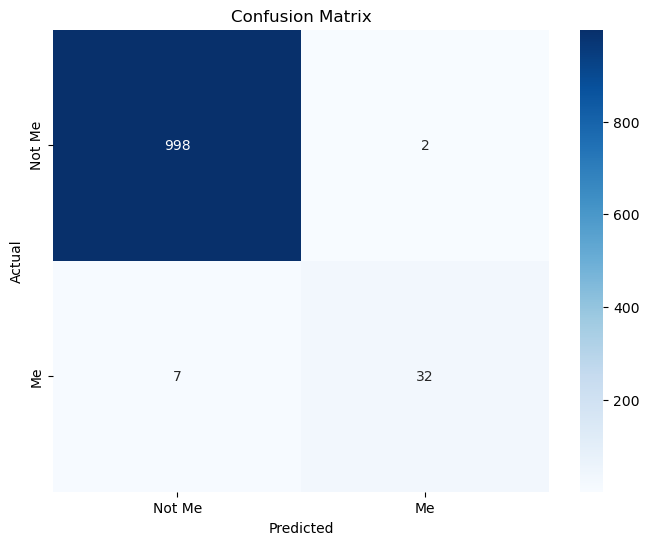


Test Classification Report:
              precision    recall  f1-score   support

      Not Me       0.99      1.00      1.00      1000
          Me       0.94      0.82      0.88        39

    accuracy                           0.99      1039
   macro avg       0.97      0.91      0.94      1039
weighted avg       0.99      0.99      0.99      1039



In [67]:
# Evaluate model menggunakan directory test set

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate model on the test set
test_predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
test_y_pred = (test_predictions > 0.8).astype("int32").flatten()
test_y_true = test_generator.classes

# Confusion Matrix
test_cm = confusion_matrix(test_y_true, test_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Me", "Me"], yticklabels=["Not Me", "Me"])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\nTest Classification Report:")
print(classification_report(test_y_true, test_y_pred, target_names=["Not Me", "Me"]))


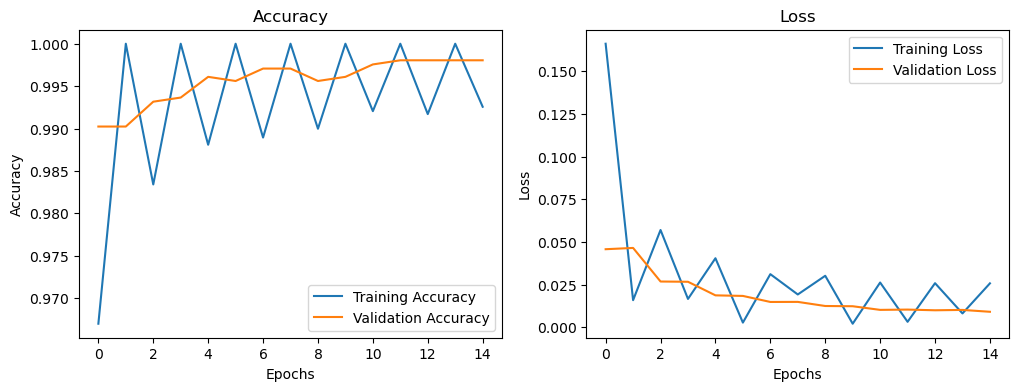

In [16]:
# Plot training history untuk visualisasi proses training

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


## Save dan Load Model

In [44]:
# Set model ke mode Inference
model.trainable = False
for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False

# Save class indices dengan JSON
class_indices = train_generator.class_indices
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)

# Save model dalam dua format .keras dan .h5
model.save('FaceNet_fineTuned_model_NEOFreeze.keras')
model.save('FaceNet_fineTuned_model_NEOFreeze.h5')

In [45]:
# Load class indices
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

# Reverse the mapping to get index-to-class
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)
# Output: {0: 'not_me', 1: 'me'}


# Required Imports
from tensorflow.keras.models import load_model
from keras.saving import register_keras_serializable
import tensorflow as tf

# Register the l2_normalize Function berdasar requirement DNN
@register_keras_serializable(package="custom")
def l2_normalize(x, axis=None, epsilon=1e-12):
    return tf.math.l2_normalize(x, axis=axis, epsilon=epsilon)

# Register the scaling Function berdasar requirement DNN
@register_keras_serializable(package="custom")
def scaling(x, **kwargs):  # Accept additional keyword arguments
    return x / 255.0


# Load the Model
try:
    # Pass the registered custom functions
    model_T = load_model(
        'FaceNet_fineTuned_model_NEOFreeze.keras',
        custom_objects={"l2_normalize": l2_normalize, "scaling": scaling}
    )
    
    # Set model ke model Inference untuk memastikan
    model_T.trainable = False
    for layer in model_T.layers:
        if hasattr(layer, 'trainable'):
            layer.trainable = False

    print("Model loaded successfully!")

except Exception as e:
    print("Error loading model:", e)


{0: 'not_me', 1: 'me'}
Model loaded successfully!


c:\Users\Michael Dimas\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Uji Coba Penggunaan Model

In [ ]:
# TEST IMAGES langsung in 20 iteration Images dataset
# untuk melihat sekilas cepat apakah model berhasil dengan dataset yang dipakai

# Specify the folder path
folder_path1 = './DATASET_preprocessed/me/'
folder_path2 = './DATASET_preprocessed/not_me/'

dataRand = [folder_path1, folder_path2]

for folder_path in dataRand:

    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Ensure there are images in the folder
    if len(image_files) == 0:
        print("No images found in the folder!")
    else:
        # Perform 20 iterations
        for i in range(1, 21):
            # Select a random image from the folder
            random_image = random.choice(image_files)
            random_image_path = os.path.join(folder_path, random_image)

            # Load and preprocess the randomly selected image
            img = image.load_img(random_image_path, target_size=(224, 224))  # Resize to model's input size
            img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

            # Predict using the model
            prediction = model.predict(img_array)
            similarity_score = prediction[0][0]

            # Output the results
            print(f"Iteration {i}:")
            print(f"Randomly selected image: {random_image_path}")
            print("It's you!" if similarity_score > 0.8 else "Not you!")
            print(f"Similarity Score: {similarity_score:.2f}")
            print("-" * 50)  # Separator for better readability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Iteration 1:
Randomly selected image: ./DATASET_preprocessed/me/me_205.jpg
It's you!
Similarity Score: 0.91
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Iteration 2:
Randomly selected image: ./DATASET_preprocessed/me/me_181.jpg
It's you!
Similarity Score: 0.95
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Iteration 3:
Randomly selected image: ./DATASET_preprocessed/me/me_67.jpg
It's you!
Similarity Score: 0.96
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Iteration 4:
Randomly selected image: ./DATASET_preprocessed/me/me_280.jpg
Not you!
Similarity Score: 0.16
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Iteration 5:
Randomly selected image: ./DATASET_preprocessed/me/me_44.jpg
It's you!
Similarity Score: 0.93
--------------------------------------------------
1/1 ━━━━━━━━━

### Uji Coba Model dalam Real Time

In [73]:
IP_TARGET = '192.168.1.5'

# Function to get the Wi-Fi IP address
def get_wifi_ip():
    wifi_ip = "Not Connected"
    try:
        # Iterate through network interfaces
        for iface, addrs in psutil.net_if_addrs().items():
            if "Wi-Fi" in iface or "wlan" in iface.lower():  # Look for Wi-Fi interface
                for addr in addrs:
                    if addr.family == socket.AF_INET:  # IPv4 address
                        wifi_ip = addr.address
                        break
    except Exception as e:
        print("Error fetching Wi-Fi IP:", e)
    return wifi_ip

# Function to match IP with the target
def matching_IP(current_ip, target_ip):
    return "Correct Room" if current_ip == target_ip else "Wrong Room"

# Load the DNN model for face detection
model_path = "DNN/deploy.prototxt"  # Replace with your deploy.prototxt path
weights_path = "DNN/res10_300x300_ssd_iter_140000.caffemodel"  # Replace with your model weights path
net = cv2.dnn.readNetFromCaffe(model_path, weights_path)

# Open webcam
cap = cv2.VideoCapture(0)

while True:
    wifi_ip = get_wifi_ip()
    status = matching_IP(wifi_ip, IP_TARGET)

    # Read frame from the webcam
    ret, frame = cap.read()
    if not ret:
        break

    # Display the Wi-Fi IP address and room status at the top-left corner
    cv2.putText(frame, f"Wi-Fi IP: {wifi_ip}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    cv2.putText(frame, f"Room Status: {status}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0) if status == "Correct Room" else (0, 0, 255), 2)

    # Get frame dimensions
    (h, w) = frame.shape[:2]

    # Prepare the frame for the DNN
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(300, 300),
                                 mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    net.setInput(blob)
    detections = net.forward()

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Confidence threshold
            # Get bounding box for the face
            box = detections[0, 0, i, 3:7] * [w, h, w, h]
            (x1, y1, x2, y2) = box.astype("int")

            # Ensure bounding box stays within the frame
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

            # Extract the face from the frame
            face = frame[y1:y2, x1:x2]
            if face.size == 0:  # Skip invalid crops
                continue
            
            # Preprocess the face for the classification model
            try:
                face_resized = cv2.resize(face, (224, 224))  # Resize to match model input
            except Exception as e:
                print("Error resizing face:", e)
                continue
            
            face_normalized = face_resized / 255.0
            face_array = np.expand_dims(face_normalized, axis=0)

            # Predict using the trained model
            prediction = model.predict(face_array, verbose=0)  # Suppress logging
            similarity_score = prediction[0][0] * 100  # Convert to percentage
            label = "You" if similarity_score > 80 else "Not You"

            # Draw a rectangle and label around the face
            color = (0, 255, 0) if label == "You" else (0, 0, 255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"{label} ({similarity_score:.2f}%)", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the frame with rectangles, IP, and room status
    cv2.imshow('Face Recognition', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()


<div style="text-align: center;">
    <img src="realtime_result.png" alt="Real Time Result" style="border: 2px solid #ddd; border-radius: 8px; padding: 5px; width: 70%;">
    <p style="font-style: italic; color: #555;">Figure 1: Real-time result displayed using the model.</p>
</div>


### Uji Coba Model dalam bentuk Snapshot

In [62]:
# Paths to the model and weights
model_path = "DNN/deploy.prototxt"  # Replace with your deploy.prototxt path
weights_path = "DNN/res10_300x300_ssd_iter_140000.caffemodel"  # Replace with your model weights path
net = cv2.dnn.readNetFromCaffe(model_path, weights_path)

# Create a directory for saving images
output_dir = "captured_faces"  # Directory to save images
os.makedirs(output_dir, exist_ok=True)

# Initialize the webcam
cap = cv2.VideoCapture(0)

print("Press 'c' to capture an image and 'q' to quit.")
status = True
while status:
    ret, frame = cap.read()
    if not ret:
        break

    # Get frame dimensions
    (h, w) = frame.shape[:2]

    # Prepare the frame for the DNN
    blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(300, 300),
                                 mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
    net.setInput(blob)
    detections = net.forward()

    # Loop through detections and process faces
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Confidence threshold for face detection
            # Get bounding box for the face
            box = detections[0, 0, i, 3:7] * [w, h, w, h]
            (x1, y1, x2, y2) = box.astype("int")

            # Ensure bounding box stays within the frame
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w, x2), min(h, y2)

            # Crop the face from the frame
            face = frame[y1:y2, x1:x2]

            # Check if key pressed
            key = cv2.waitKey(1) & 0xFF
            if key == ord('c'):
                # Save the cropped face image
                img_path = os.path.join(output_dir, f"captured_face.jpg")
                cv2.imwrite(img_path, face)
                print(f"Saved {img_path}")
                status = False  # Exit after saving the first face
            elif key == ord('q'):
                break

    # Display the frame with bounding box (optional for visual feedback)
    cv2.imshow("Capture Images", frame)

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()


Press 'c' to capture an image and 'q' to quit.
Saved captured_faces\captured_face.jpg


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model  # If the model isn't already loaded

# Load the image
img_path = 'captured_faces/captured_face.jpg'  # Ensure correct path format

# Preprocess the image for prediction
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match input size of model

# Convert the image to array and normalize it
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict using the model
prediction = model.predict(img_array, verbose=0)
print("It's you!" if prediction[0][0] > 0.8 else "Not you!")
print(prediction)

# Display the image using matplotlib
plt.imshow(img)  # Display image
plt.axis('off')  # Hide axis
plt.show()  # Show image
